Get the data from the google drive. You need to update this based on where your data is in the google drive

In [1]:
import os
DATA_DRIVE = 'data'
DRIVE_PATH = os.path.join('/storage/ice1/6/1/ssubedi33', DATA_DRIVE)
print(os.listdir(DRIVE_PATH))

['.idea', 'LICENSE.txt', 'test_seen.jsonl', 'img', 'test.jsonl', 'README.md', 'dev_seen.jsonl', 'dev.jsonl', '.DS_Store', 'train.jsonl']


Import torch and reload external modules

In [2]:
# Just run this block. Please do not modify the following code.
import pandas as pd
import torch

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Now lets check your GPU availability and load some sanity checkers. By default you should be using your gpu for this assignment if you have one available.

In [3]:
# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cuda


Load data here. train.jsonl and dev.jsonl file contains id, image location, label and caption in the image.

In [9]:
path = DRIVE_PATH + '/train.jsonl'
train_data=pd.read_json(path,lines=True)
print(f"Train set size: {len(train_data)}")

Train set size: 8500


In [10]:
path = DRIVE_PATH + '/test_seen.jsonl'
test_data=pd.read_json(path,lines=True)
print(f"Test set size: {len(test_data)}")

Test set size: 1000


In [11]:
path = DRIVE_PATH + '/dev_seen.jsonl'
val_data=pd.read_json(path,lines=True)
print(f"Val set size: {len(val_data)}")

Val set size: 500


Split train data in to train, validation set. dev data will be test set.

In [12]:
from sklearn.model_selection import train_test_split

print(f"Train set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")
print(test_data.head())


Train set size: 8500
Validation set size: 500
Test set size: 1000
      id            img  label                                         text
0  16395  img/16395.png      1                     handjobs sold seperately
1  37405  img/37405.png      1         introducing fidget spinner for women
2  94180  img/94180.png      1  happy pride month let's go beat up lesbians
3  54321  img/54321.png      1       laughs in [majority of u.s crime rate]
4  97015  img/97015.png      1       finds out those 72 virgins.. are goats


Fine Tuning CLIP model.
This part of the code imports the pretrained model and processor from openAI.
model contains weights and actual architecture.
processor contains tokenizer for words and feature extractor for image. These are used to convert image and caption into numbers that computer will understand.


In [13]:
from transformers import CLIPModel, CLIPProcessor

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


This is a class to tokenize dataset. It takes an input and output tokens for text and image. It uses the same tokenizer that CLIP uses.

In [14]:
from torch.utils.data import Dataset
from PIL import Image
import torch

class MemeDataset(Dataset):
    def __init__(self, dataframe, processor, image_root_dir, max_length = 70):
        self.df = dataframe.reset_index(drop=True)
        self.processor = processor
        #directory where all images are
        self.image_root = image_root_dir
        #to make sure all captions are of same length
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        #get the data at idx
        row = self.df.loc[idx]
        #extract path to image
        img_path = f"{self.image_root}/{row['img'].split('/')[-1]}"
        #load image in RGB
        image = Image.open(img_path).convert("RGB")
        #load text
        text = row['text']
        #load label
        label = torch.tensor(row['label'], dtype=torch.float)

        # Convert text and image to tokens
        inputs = self.processor(
            text=text,
            images=image,
            return_tensors="pt",
            padding='max_length',
            max_length=self.max_length,
            truncation=True)

        # Remove batch dimension (1) from processor outputs
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        #add label
        inputs["labels"] = label
        return inputs


Implement MemeDataset class to the train data, validation data, and test data.

In [15]:
from torch.utils.data import DataLoader
import torch

BATCH_SIZE = 32
train_dataset = MemeDataset(train_data, processor, image_root_dir = DRIVE_PATH + "/img")
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = MemeDataset(val_data, processor, image_root_dir = DRIVE_PATH + "/img")
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = MemeDataset(test_data, processor, image_root_dir = DRIVE_PATH + "/img")
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Binary classification head at the end of CLIP model. It uses CLIP embeddings from both text and image inputs, and combines them to make a prediction.


In [16]:
import torch.nn as nn

class CLIPBinaryClassifier(nn.Module):
    def __init__(self, clip_model, dropout_prob):
        super().__init__()
        #parent model - pretrained openAI CLIP model
        self.clip = clip_model
        #get image and text embeddings
        dim = self.clip.config.projection_dim
        #Linear classification head with two outputs - Hateful or Not Hateful
        self.classifier = nn.Sequential(
            nn.Linear(dim * 2, dim * 4),
            nn.GELU(),
            nn.Dropout(dropout_prob),
            nn.LayerNorm(dim * 4),
            nn.Linear(dim * 4, dim * 2),
            nn.GELU(),
            nn.Dropout(dropout_prob),
            nn.Linear(dim * 2, 1))
        
        self._init_weights()
    #Initialize weights 
    def _init_weights(self):
        for module in self.classifier:
            if isinstance(module, nn.Linear):
                nn.init.xavier_normal_(module.weight)
                nn.init.zeros_(module.bias)

    def forward(self, input_ids, attention_mask, pixel_values):
        #forward pass on tokenized inputs, outputs image and text embeddings
        with torch.no_grad():
            outputs = self.clip(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values)
        combined = torch.cat([outputs.image_embeds, outputs.text_embeds], dim=1)
        logits = self.classifier(combined)
        return logits.squeeze(-1)

Training Loop

Epoch 1/10: 100%|██████████| 266/266 [03:08<00:00,  1.41it/s, loss=0.429]


Epoch 1 | Train Loss: 0.6056 | Val Loss: 0.8299 | Train AUC: 0.7177 | Val AUC: 0.6534


Epoch 2/10: 100%|██████████| 266/266 [03:00<00:00,  1.47it/s, loss=0.514]


Epoch 2 | Train Loss: 0.4965 | Val Loss: 0.7316 | Train AUC: 0.8157 | Val AUC: 0.6696


Epoch 3/10: 100%|██████████| 266/266 [03:00<00:00,  1.48it/s, loss=0.671]


Epoch 3 | Train Loss: 0.4408 | Val Loss: 0.7156 | Train AUC: 0.8609 | Val AUC: 0.6906


Epoch 4/10: 100%|██████████| 266/266 [02:58<00:00,  1.49it/s, loss=0.498]


Epoch 4 | Train Loss: 0.3812 | Val Loss: 0.7797 | Train AUC: 0.9004 | Val AUC: 0.6993


Epoch 5/10: 100%|██████████| 266/266 [02:58<00:00,  1.49it/s, loss=0.195]


Epoch 5 | Train Loss: 0.3117 | Val Loss: 0.8335 | Train AUC: 0.9376 | Val AUC: 0.7099


Epoch 6/10: 100%|██████████| 266/266 [02:58<00:00,  1.49it/s, loss=0.227]


Epoch 6 | Train Loss: 0.2498 | Val Loss: 0.9466 | Train AUC: 0.9633 | Val AUC: 0.7178


Epoch 7/10: 100%|██████████| 266/266 [02:58<00:00,  1.49it/s, loss=0.222] 


Epoch 7 | Train Loss: 0.1932 | Val Loss: 0.9152 | Train AUC: 0.9797 | Val AUC: 0.7095


Epoch 8/10: 100%|██████████| 266/266 [02:58<00:00,  1.49it/s, loss=0.428] 


Epoch 8 | Train Loss: 0.1457 | Val Loss: 1.0052 | Train AUC: 0.9900 | Val AUC: 0.7192


Epoch 9/10: 100%|██████████| 266/266 [02:58<00:00,  1.49it/s, loss=0.0889]


Epoch 9 | Train Loss: 0.1208 | Val Loss: 1.1084 | Train AUC: 0.9929 | Val AUC: 0.7181


Epoch 10/10: 100%|██████████| 266/266 [02:59<00:00,  1.48it/s, loss=0.0377]


Epoch 10 | Train Loss: 0.0958 | Val Loss: 1.1315 | Train AUC: 0.9957 | Val AUC: 0.7224


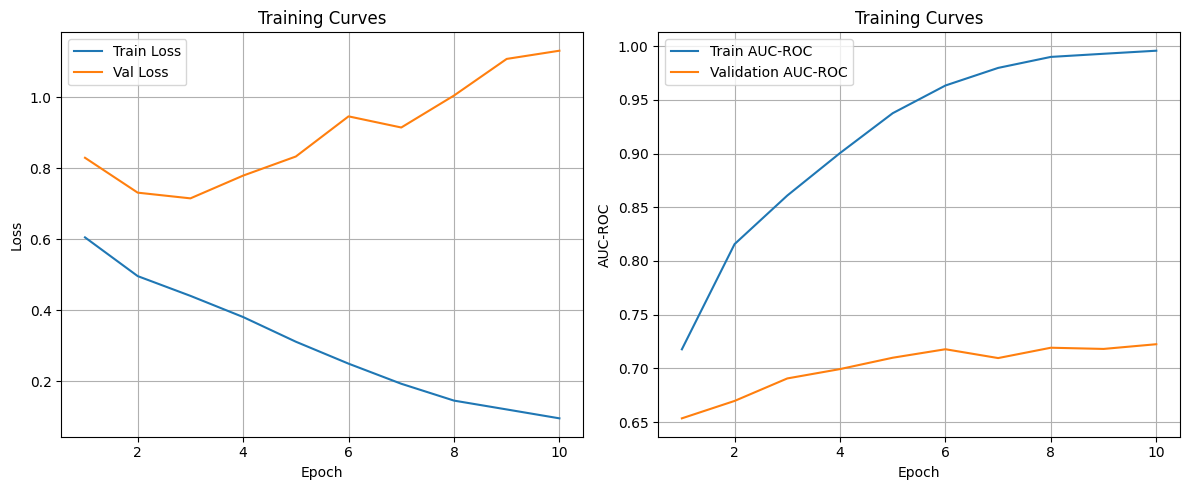

In [18]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score 
from tqdm import tqdm  # For progress bars

# Initialize classifier, takes the CLIP model and dropout probability as input
classifier = CLIPBinaryClassifier(model, dropout_prob=0.2).to(device)

# Freeze CLIP backbone, to make the model faster
for param in classifier.clip.parameters():
    param.requires_grad = False

# Optimizer - now includes all trainable parameters (classifiers + alpha)
learning_rate = 0.0001
#reduce the learning rate for alpha
optimizer = torch.optim.AdamW([{'params': classifier.classifier.parameters()}], lr=learning_rate)

# Cross entropy Loss and epochs
criterion = nn.BCEWithLogitsLoss()
epochs = 10

# Track losses, auc scores and alpha
train_losses = []
val_losses = []
ensemble_weights = [] 
train_auc_scores = []
val_auc_scores = []

# Training loop
for epoch in range(epochs):
    #Train classifier
    classifier.train()
    #Initialize loss
    total_train_loss = 0
    #Initialize logits for AUCROC
    train_logits = []
    train_labels = []
    #shows the progress bar 
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
    
    for batch in progress_bar:
        # Move data to cuda for training
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        optimizer.zero_grad()
        logits = classifier(input_ids, attention_mask, pixel_values)
        loss = criterion(logits, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Track stats
        total_train_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})
                               
        # Collect logits and labels, first stack into 1 tensor
        train_logits.append(logits.detach().cpu())
        train_labels.append(labels.detach().cpu())
     
    # Compute train AUC-ROC
    train_preds = torch.cat(train_logits).numpy()
    train_targets = torch.cat(train_labels).numpy()
    train_auc = roc_auc_score(train_targets, train_preds)
    train_auc_scores.append(train_auc)
    
    # Validation
    classifier.eval()
    total_val_loss = 0
    val_logits = []
    val_labels = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)
            #Run the model
            logits = classifier(input_ids, attention_mask, pixel_values)
            loss = criterion(logits, labels)
            total_val_loss += loss.item()
    
            #logits and labels to cpu
            val_logits.append(logits.cpu())
            val_labels.append(labels.cpu())
    
    #validation AUC-ROC, first stack into 1 tensor
    val_preds = torch.cat(val_logits).numpy()
    val_targets = torch.cat(val_labels).numpy()
    val_auc = roc_auc_score(val_targets, val_preds)
    val_auc_scores.append(val_auc)
                               
    # Save epoch metrics
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    #Print Epoch metrics
    print(f"Epoch {epoch+1} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Train AUC: {train_auc:.4f} | "
          f"Val AUC: {val_auc:.4f}")

# Plotting
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Curves')
plt.legend()
plt.grid(True)

#AUC-ROC plot
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_auc_scores, label='Train AUC-ROC')
plt.plot(range(1, epochs+1), val_auc_scores, label='Validation AUC-ROC')
plt.xlabel('Epoch')
plt.ylabel('AUC-ROC')
plt.title('Training Curves')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Accuracy

In [22]:
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np
import torch

classifier.eval()

# Store predictions and labels
logits = []
test_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        outputs = classifier(input_ids, attention_mask, pixel_values)
        
        #model output
        logits.append(outputs.cpu())
        #Actual label
        test_labels.append(labels.cpu())

# Stack each batch output into one large tensor
logits = torch.cat(logits).numpy()  
test_labels = torch.cat(test_labels).numpy()  

# Convert logits to probabilities using sigmoid
probs = torch.sigmoid(torch.tensor(logits)).numpy()

# Convert probabilities to class predictions using threshold 0.5, could change this threshold
preds = (probs >= 0.5).astype(int)


# Function to print metrics
acc = accuracy_score(test_labels, preds)
auc = roc_auc_score(test_labels, probs)
print("\nEvaluation Results:")
print(f"  Accuracy: {acc:.4f}")
print(f"  ROC AUC: {auc:.4f}")


Evaluation Results:
  Accuracy: 0.6690
  ROC AUC: 0.7856


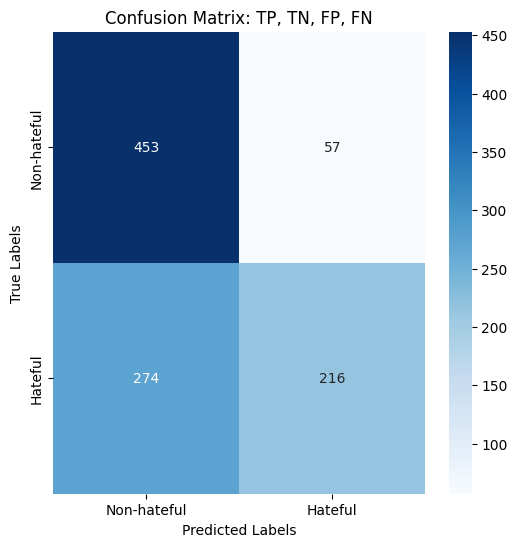

In [23]:
from sklearn.metrics import roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(test_labels, preds)
tn, fp, fn, tp = cm.ravel()
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-hateful', 'Hateful'],
            yticklabels=['Non-hateful', 'Hateful'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix: TP, TN, FP, FN')
plt.show()
